<a href="https://colab.research.google.com/github/xodud5654/PDM05/blob/main/py-tensorflow/DL4-autoML/private_file/last_acc_0.87.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import  MobileNetV2, preprocess_input
import tensorflow.keras as keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import tensorflow as tf
from keras.utils import np_utils
from keras.models import load_model
from keras.datasets import cifar10
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
# import cv2
print(tf.__version__)

2.7.0


In [2]:
tf.keras.backend.clear_session()  # For memory

# GPU check
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print("#### ", len(gpus), "Physical GPUs,",
                 len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
else:
    print('#### No CUDA supported GPU in this computer.')

####  1 Physical GPUs, 1 Logical GPUs


In [3]:
from keras.datasets import cifar10
# load dataset
(trainX, trainy), (testX, testy) = cifar10.load_data()

from sklearn.model_selection import train_test_split
X_train, X_test,y_train , y_test = train_test_split(trainX,trainy,test_size=0.1,stratify=trainy, random_state=42)

X_train, y_train,X_test, y_test = X_test,y_test, testX, testy
print('Train: X=%s, y=%s' % (X_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (X_test.shape, y_test.shape))

170508288/170498071 [==============================] - 2s 0us/step
Train: X=(5000, 32, 32, 3), y=(5000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)


In [4]:
# set up image augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
    #zoom_range=0.3
    )
datagen.fit(X_train)

In [5]:
#reshape into images
img_rows,img_cols, channels = 32,32,3

X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, channels)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, channels)
input_shape = (img_rows, img_cols, 1)
print('x_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

x_train shape: (5000, 32, 32, 3)
5000 train samples
10000 test samples


In [6]:
#convert integers to float; normalise and center the mean
X_train=X_train.astype("float32")  
X_test=X_test.astype("float32")

In [7]:
num_classes=10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [8]:
# plotting helper function
def plothist(hist):
    plt.plot(hist.history['acc'])
    plt.plot(hist.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [9]:
TL_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
TL_base.summary()

9420800/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                

In [29]:
# build and compile the model  (roughly following the VGG paper)
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

opt = tf.keras.optimizers.SGD(learning_rate=5e-4) #(+idea)


model = Sequential()
model.add(keras.Input(shape=(32,32,3)))
model.add(layers.UpSampling2D((7,7)))  # 32*7 = 224
model.add(TL_base)
model.add(layers.GlobalAveragePooling2D()) # (7,7,2048) => (2048,)
model.add(layers.Flatten())
model.add(layers.BatchNormalization())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=opt)

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 up_sampling2d (UpSampling2D  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                          

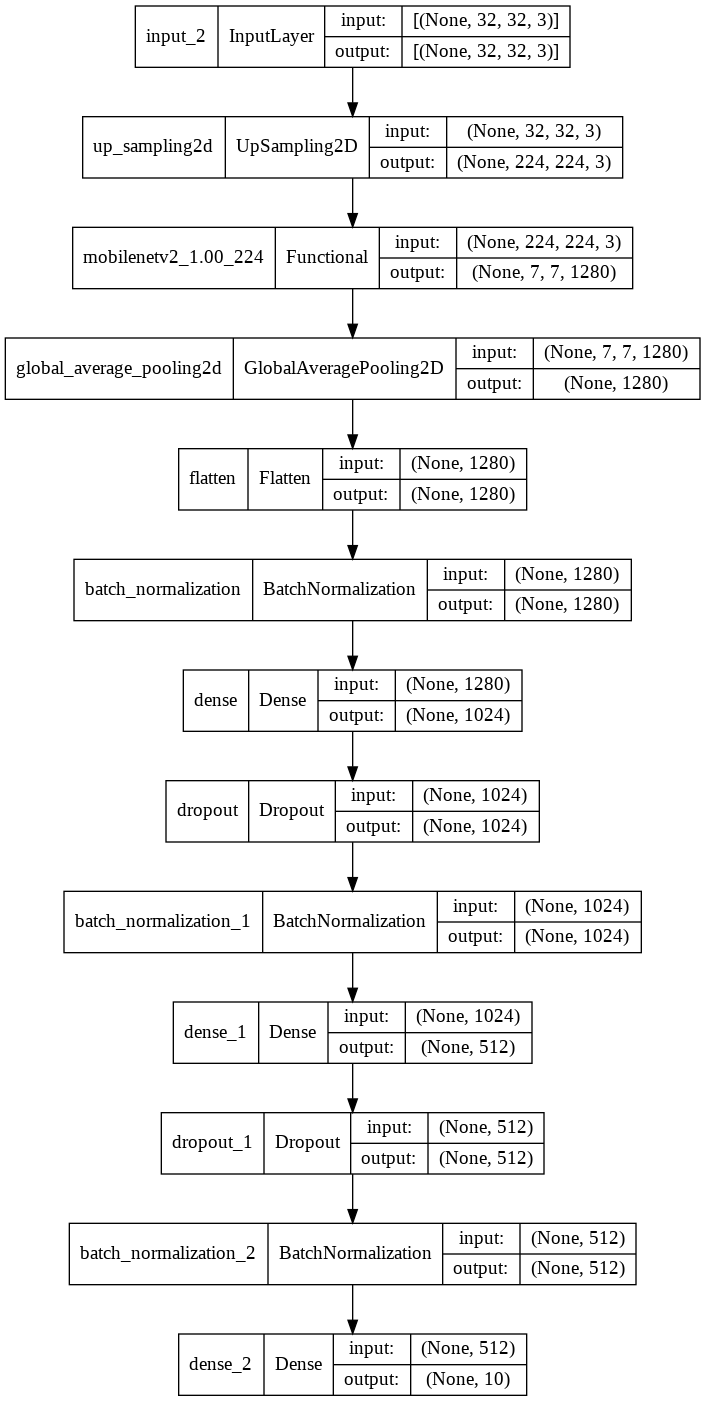

In [12]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

In [13]:
from tensorflow.keras import layers, models, callbacks

mc_callback = callbacks.ModelCheckpoint(filepath="./model/cifar10_pct10_mobilenetV2S_SGD_best_weights.{epoch:03d}-{val_accuracy:.4f}.hdf5", 
                              monitor='val_accuracy', verbose=0, save_best_only=True)
es_callback = callbacks.EarlyStopping(monitor='val_accuracy', 
                            mode='max', verbose=1, patience=5)

In [15]:
epochs = 500
BATCH_SIZE = 50
history = model.fit(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE, seed=1234), # BATCH_SIZE = 50
                 steps_per_epoch=X_train.shape[0]//BATCH_SIZE, 
                 epochs=epochs, verbose=1, 
                 callbacks=[mc_callback, es_callback], 
                 validation_data=(X_test,y_test))    

Epoch 1/500
100/100 [==============================] - ETA: 0s - loss: 3.0043 - accuracy: 0.1100

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


100/100 [==============================] - 97s 813ms/step - loss: 3.0043 - accuracy: 0.1100 - val_loss: 2.3935 - val_accuracy: 0.1665
Epoch 2/500
100/100 [==============================] - 79s 790ms/step - loss: 2.8472 - accuracy: 0.1246 - val_loss: 2.4403 - val_accuracy: 0.1392
Epoch 3/500
100/100 [==============================] - 78s 784ms/step - loss: 2.7180 - accuracy: 0.1512 - val_loss: 2.4208 - val_accuracy: 0.1374
Epoch 4/500
100/100 [==============================] - 80s 801ms/step - loss: 2.5821 - accuracy: 0.1802 - val_loss: 2.3491 - val_accuracy: 0.1536
Epoch 5/500
100/100 [==============================] - 78s 787ms/step - loss: 2.4416 - accuracy: 0.2170 - val_loss: 2.2120 - val_accuracy: 0.1936
Epoch 6/500
100/100 [==============================] - 96s 961ms/step - loss: 2.3226 - accuracy: 0.2368 - val_loss: 2.1604 - val_accuracy: 0.2063
Epoch 7/500
100/100 [==============================] - 80s 805ms/step - loss: 2.2320 - accuracy: 0.2710 - val_loss: 2.0687 - val_accurac

In [16]:
model.evaluate(X_test, y_test, batch_size=50)

tf.keras.backend.clear_session()  # For memory
TL_base.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(TL_base.layers))

200/200 [==============================] - 24s 117ms/step - loss: 0.4208 - accuracy: 0.8660
Number of layers in the base model:  154


In [17]:
# Fine-tune from this layer onwards
fine_tune_at = 107  # 81, 107 for mobilenetV2

# Freeze all the layers before the `fine_tune_at` layer
for layer in TL_base.layers[:fine_tune_at]:
  layer.trainable =  False

In [18]:
# Compile model
model.compile(optimizer=opt, 
                loss='categorical_crossentropy',  # sparse_categorical_crossentropy
                metrics = ['accuracy'])

In [19]:
history_dict = history.history
loss = history_dict['loss']

INITIAL_EPOCHS = len(loss)
FINE_TUNE_EPOCHS = 100
TOTAL_EPOCHS = INITIAL_EPOCHS + FINE_TUNE_EPOCHS #

In [20]:
history_fine = model.fit(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE, seed=1234), # BATCH_SIZE = 50
                 steps_per_epoch=X_train.shape[0]//BATCH_SIZE, 
                 initial_epoch=INITIAL_EPOCHS,
                 epochs=epochs, verbose=1, 
                 callbacks=[mc_callback, es_callback], 
                 validation_data=(X_test,y_test))   

Epoch 129/500
100/100 [==============================] - 45s 414ms/step - loss: 0.3136 - accuracy: 0.8980 - val_loss: 0.4203 - val_accuracy: 0.8658
Epoch 130/500
100/100 [==============================] - 40s 400ms/step - loss: 0.3054 - accuracy: 0.9038 - val_loss: 0.4202 - val_accuracy: 0.8666
Epoch 131/500
100/100 [==============================] - 40s 400ms/step - loss: 0.2982 - accuracy: 0.9002 - val_loss: 0.4151 - val_accuracy: 0.8686
Epoch 132/500
100/100 [==============================] - 40s 401ms/step - loss: 0.3075 - accuracy: 0.9016 - val_loss: 0.4121 - val_accuracy: 0.8687
Epoch 133/500
100/100 [==============================] - 40s 399ms/step - loss: 0.3093 - accuracy: 0.8994 - val_loss: 0.4116 - val_accuracy: 0.8687
Epoch 134/500
100/100 [==============================] - 40s 400ms/step - loss: 0.2984 - accuracy: 0.9038 - val_loss: 0.4121 - val_accuracy: 0.8682
Epoch 135/500
100/100 [==============================] - ETA: 0s - loss: 0.2935 - accuracy: 0.9034

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


100/100 [==============================] - 40s 404ms/step - loss: 0.2935 - accuracy: 0.9034 - val_loss: 0.4128 - val_accuracy: 0.8691
Epoch 136/500
100/100 [==============================] - 40s 400ms/step - loss: 0.2922 - accuracy: 0.9048 - val_loss: 0.4120 - val_accuracy: 0.8690
Epoch 137/500
100/100 [==============================] - 40s 400ms/step - loss: 0.2852 - accuracy: 0.9102 - val_loss: 0.4140 - val_accuracy: 0.8688
Epoch 138/500
100/100 [==============================] - 40s 402ms/step - loss: 0.2919 - accuracy: 0.9006 - val_loss: 0.4104 - val_accuracy: 0.8710
Epoch 139/500
100/100 [==============================] - 40s 401ms/step - loss: 0.2885 - accuracy: 0.9050 - val_loss: 0.4111 - val_accuracy: 0.8703
Epoch 140/500
100/100 [==============================] - 40s 398ms/step - loss: 0.2704 - accuracy: 0.9110 - val_loss: 0.4082 - val_accuracy: 0.8703
Epoch 141/500
100/100 [==============================] - 40s 399ms/step - loss: 0.2789 - accuracy: 0.9064 - val_loss: 0.4086 -

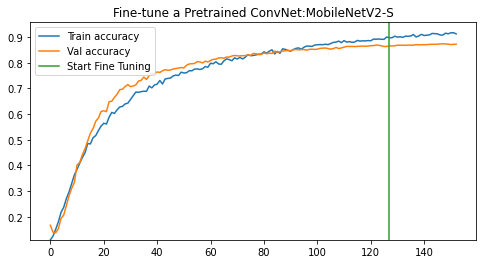

In [21]:
# Display training curve
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']

plt.figure(figsize=(8, 4))

plt.plot(acc, label='Train accuracy')
plt.plot(val_acc, label='Val accuracy')
# plt.ylim([0.8, 1])
plt.plot([INITIAL_EPOCHS-1, INITIAL_EPOCHS-1], plt.ylim(ymin=acc[0]), label='Start Fine Tuning')
plt.title("Fine-tune a Pretrained ConvNet:MobileNetV2-S")
plt.legend(loc='upper left')

plt.show()

## cifar10_pct10_mobilenetV2S_SGD_best_weights.148-0.8741.hdf5

In [23]:

from keras.models import load_model

# returns a compiled model
# identical to the previous one
model = load_model('./model/cifar10_pct10_mobilenetV2S_SGD_best_weights.148-0.8741.hdf5')

In [24]:
y_test_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix
y_test_pred=np.argmax(y_test_pred, axis=1)
y_test=np.argmax(y_test, axis=1)
print(confusion_matrix(y_test, y_test_pred))


[[913  12  13   6   5   0   5   9  23  14]
 [  2 962   0   0   1   1   2   0   1  31]
 [ 25   0 843  18  26  31  47   6   3   1]
 [ 13   2  24 647  35 146 101  18   2  12]
 [  5   0  34  14 843  18  42  41   2   1]
 [  1   1  19  85  20 816  28  27   1   2]
 [  4   0  15  15   3   2 957   3   1   0]
 [  9   1  11  12  21  25  10 906   0   5]
 [ 34  21   5   4   2   0   4   1 910  19]
 [  9  35   0   1   0   0   1   4   6 944]]


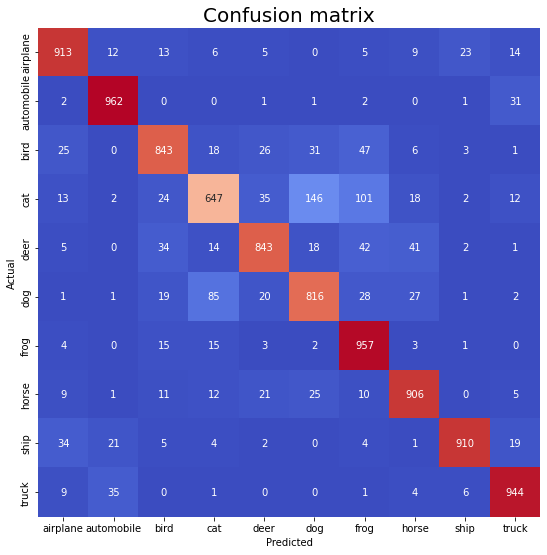

In [25]:
cm = confusion_matrix(y_test, y_test_pred)

import seaborn as sns
plt.figure(figsize=(9,9))
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
sns.heatmap(cm, cbar=False, xticklabels=classes, yticklabels=classes, fmt='d', annot=True, cmap=plt.cm.coolwarm)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion matrix', fontsize=20)
plt.show()


In [28]:
from sklearn.metrics import f1_score, accuracy_score

print("f1_score : ",f1_score(y_test, y_test_pred,average="macro"))
print("f1_score : ",f1_score(y_test, y_test_pred,average="micro"))
print("accuracy_score : ",accuracy_score(y_test, y_test_pred))

f1_score :  0.8725784949862317
f1_score :  0.8741
accuracy_score :  0.8741
